In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import cross_val_score

Improt the dataset

In [3]:
#setup display options
pd.set_option('display.max_columns', None)
pd.set_option('display.min_rows', 15)
df = pd.read_csv("..\data\data_cleaned.csv",index_col=[0])


In [4]:
df.head()

,id,type of property,subtype of property,locality,latitude,longitude,street,postalCode,price,type of sale,number of bedrooms,living area,livable area,fully equipped kitchen,furnished,open fire,terrace,terrace area,garden,garden area,total property area,total land area,number of facades,swimming pool,state of the building,Gemeente,Province,Population( per province),Area(per province),Density,kitchen,price per sqr
0,10689265,HOUSE,MIXED_USE_BUILDING,Koekelberg,50.863091,4.329928,Rue du Noyer 86,1081,575000.0,residential_sale,3,0,220.0,installed,False,False,True,0.0,False,0.0,220.0,71.0,2.0,False,good,Koekelberg,Brussel,1208542.0,162.4,7442.0,NaN,2613.636364
1,10687297,HOUSE,EXCEPTIONAL_PROPERTY,Beveren,51.224437,4.246054,NaN,9120,695000.0,residential_sale,4,28,269.0,hyper_equipped,False,False,True,41.0,True,300.0,269.0,583.0,3.0,False,as_new,Beveren,Oost-Vlaanderen,1515064.0,3007.0,504.0,Hyper equipped,2583.643123
2,10686031,HOUSE,HOUSE,Seraing,50.598224,5.518784,Place Merlot 6,4100,144000.0,residential_sale,2,14,105.0,semi_equipped,False,False,True,0.0,True,25.0,105.0,105.0,2.0,False,good,Seraing,Liège,1106992.0,3857.0,288.0,Semi equipped,1371.428571
3,10686030,HOUSE,HOUSE,Seraing,50.601548,5.510799,Place Merlot 6,4100,199000.0,residential_sale,4,25,125.0,installed,False,False,True,108.0,True,28.0,125.0,229.0,2.0,False,good,Seraing,Liège,1106992.0,3857.0,288.0,NaN,1592.000000
4,10686027,HOUSE,VILLA,Herzele,50.891145,3.857915,Hoogstraat 20,9550,539000.0,residential_sale,4,65,370.0,hyper_equipped,False,False,True,60.0,False,0.0,370.0,911.0,4.0,False,as_new,Herzele,Oost-Vlaanderen,1515064.0,3007.0,504.0,Hyper equipped,1456.756757


In [5]:
df["subtype of property"].value_counts()
df["latitude"].isna().value_counts()

latitude
False    12976
True      2694
Name: count, dtype: int64

Data cleaning!
1. fillna
2. remove castles
3. scaling certain data
4. get dummies


In [6]:
#drop Nan rows
df.drop(df["kitchen"].isna().index)

#remove the properties without coordinates
lon_la = (df["latitude"].isna()) | (df["longitude"].isna())
df.drop(df.loc[lon_la].index,inplace=True)

#remove castles
castle = df[df["subtype of property"]=="CASTLE"].index
df.drop(castle,inplace=True)


def convert(n):
    return int(n/100)
df["digit"]=df["postalCode"].agg(convert)

#get dummies for catagorical data:
get_dummies = ["Province","type of property","kitchen","subtype of property","state of the building","garden","terrace","digit"]
df =pd.get_dummies(data=df, columns=get_dummies)

df.drop(columns=["fully equipped kitchen"],inplace=True)

#replace True with 1, and False with 0, turn them into numerical data
df.replace([True,False],[1,0],inplace=True)


In [7]:
df.shape

(12970, 153)

Remove outliners and castles

In [8]:
def remove_outliners(df,columns,n_std):
    for col in columns:

        mean = df[col].mean()
        sd = df[col].std()
        df = df[(df[col] <= mean+(n_std*sd))]
        df = df[(df[col] >= mean-(n_std*sd))]

    return df

# def remove_outliner(df, col_names):
#     for col_name in col_names:
#         q1 = df[col_name].quantile(0.25)
#         q3 = df[col_name].quantile(0.75)
#         iqr = q3-q1 #Interquartile range
#         fence_low  = q1-1.5*iqr
#         fence_high = q3+1.5*iqr
#         df = df.loc[(df[col_name] > fence_low) & (df[col_name] < fence_high)]

#     return df



In [9]:
# print(df["price"].std())
# print(df["price"].mean())
df = remove_outliners(df, ["number of bedrooms","livable area","living area",
                           "total property area","garden area","total land area","terrace area","price"],3)
df.shape

(12093, 153)

Data formatting: 
1.normalize the data
2.create X,y, split them into training and testing

In [10]:
# # fix the distributions of number of bedrooms
# df["number of bedrooms"] = np.log(df["number of bedrooms"] + 1)

#normalize these columns
columns_to_normalize = ["latitude","longitude","living area","livable area",
                        "garden area","total property area","total land area","number of facades","number of bedrooms","terrace area"]

# print(df["price"].sort_values())

In [11]:
# price would be the target
columns_to_drop = ["id","locality","street","price","type of sale"
                   ,"Density","Area(per province)",
                   "Population( per province)","price per sqr","open fire","postalCode","Gemeente"]
#Now normalize the data
y = df.loc[:,"price"].to_numpy().reshape(-1,1)
# scale the data
df[columns_to_normalize]=preprocessing.minmax_scale(df[columns_to_normalize])
X=df.drop(columns=columns_to_drop,axis=1)
X = X.to_numpy()

# X=preprocessing.normalize(X_raw) 
# print(X.shape,y.shape)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2,random_state=21)


In [12]:
print(X.shape, X_train.shape, y_train.shape)


(12093, 141) (9674, 141) (9674, 1)


visualization of the raw_data

In [13]:
df.drop(columns=columns_to_drop,axis=1).head()

,latitude,longitude,number of bedrooms,living area,livable area,furnished,terrace area,garden area,total property area,total land area,number of facades,swimming pool,Province_Antwerpen,Province_Brabant wallon,Province_Brussel,Province_Hainaut,Province_Limburg,Province_Liège,Province_Luxembourg,Province_Namur,Province_Oost-Vlaanderen,Province_Vlaams-Brabant,Province_West-Vlaanderen,type of property_APARTMENT,type of property_HOUSE,kitchen_Equipped,kitchen_Hyper equipped,kitchen_Not equipped,kitchen_Semi equipped,subtype of property_APARTMENT,subtype of property_APARTMENT_BLOCK,subtype of property_BUNGALOW,subtype of property_CHALET,subtype of property_COUNTRY_COTTAGE,subtype of property_DUPLEX,subtype of property_EXCEPTIONAL_PROPERTY,subtype of property_FARMHOUSE,subtype of property_FLAT_STUDIO,subtype of property_GROUND_FLOOR,subtype of property_HOUSE,subtype of property_KOT,subtype of property_LOFT,subtype of property_MANOR_HOUSE,subtype of property_MANSION,subtype of property_MIXED_USE_BUILDING,subtype of property_PENTHOUSE,subtype of property_SERVICE_FLAT,subtype of property_TOWN_HOUSE,subtype of property_TRIPLEX,subtype of property_VILLA,state of the building_0,state of the building_as_new,state of the building_good,state of the building_just_renovated,state of the building_to_be_done_up,state of the building_to_renovate,state of the building_to_restore,garden_False,garden_True,terrace_False,terrace_True,digit_10,digit_11,digit_12,digit_13,digit_14,digit_15,digit_16,digit_17,digit_18,digit_19,digit_20,digit_21,digit_22,digit_23,digit_24,digit_25,digit_26,digit_28,digit_29,digit_30,digit_31,digit_32,digit_33,digit_34,digit_35,digit_36,digit_37,digit_38,digit_39,digit_40,digit_41,digit_42,digit_43,digit_44,digit_45,digit_46,digit_47,digit_48,digit_49,digit_50,digit_51,digit_53,digit_55,digit_56,digit_60,digit_61,digit_62,digit_64,digit_65,digit_66,digit_67,digit_68,digit_69,digit_70,digit_71,digit_73,digit_75,digit_76,digit_77,digit_78,digit_79,digit_80,digit_82,digit_83,digit_84,digit_85,digit_86,digit_87,digit_88,digit_89,digit_90,digit_91,digit_92,digit_93,digit_94,digit_95,digit_96,digit_97,digit_98,digit_99
0,0.707374,0.496316,0.428571,0.000000,0.482517,0,0.000000,0.000000,0.482517,0.002797,0.333333,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0.895840,0.472693,0.571429,0.218750,0.596737,0,0.460674,0.071429,0.596737,0.022970,0.500000,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,0.569228,0.831169,0.285714,0.109375,0.214452,0,0.000000,0.005952,0.214452,0.004137,0.333333,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0.722006,0.363370,0.571429,0.507812,0.832168,0,0.674157,0.000000,0.832168,0.035893,0.666667,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
5,0.685653,0.494511,0.571429,0.125000,0.470862,0,0.112360,0.021429,0.470862,0.006698,0.333333,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Model selection :Linear Regression

0.5993530013634785
0.5922561923701131


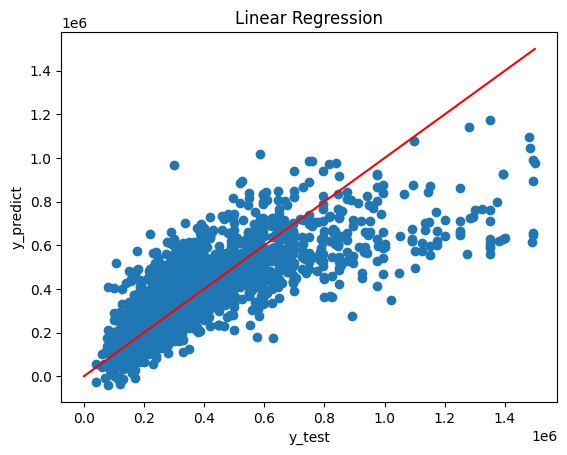

In [14]:
reg = LinearRegression()
reg.fit(X_train, y_train)

y_pred = reg.predict(X_test)
print(reg.score(X_train,y_train))
print(reg.score(X_test,y_test))

#show result
a = np.array([0,max(y_test)[0]])
plt.scatter(y_test,y_pred)
plt.plot(a,a,color="red")
plt.xlabel("y_test")
plt.ylabel("y_predict")
plt.title("Linear Regression")
plt.show()

Decision Tree?


0.799985172887
0.6581464097425571


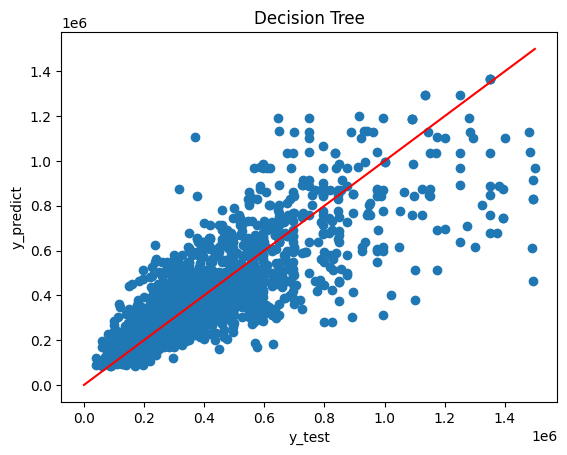

In [24]:
from sklearn.tree import DecisionTreeRegressor

#depth, minimum samples, and minimum sample split. 
#These values can be tuned to ensure that we are able to achieve early stopping.
clf = DecisionTreeRegressor(min_samples_leaf=10)

clf.fit(X_train,y_train)
y_pred=clf.predict(X_test)
print(clf.score(X_train,y_train))
print(clf.score(X_test,y_test))

#show result
a = np.array([0,max(y_test)[0]])
plt.scatter(y_test,y_pred)
plt.plot(a,a,color="red")
plt.xlabel("y_test")
plt.ylabel("y_predict")
plt.title("Decision Tree")
plt.show()


Try XGboost

0.9391610827027576
0.7879055646693809


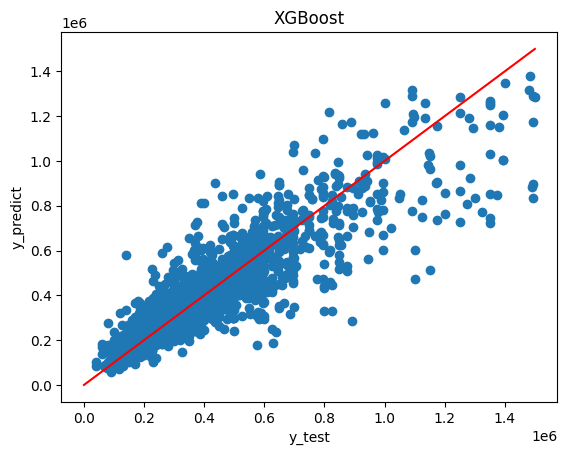

In [16]:
#use XGBregressor! instead of XGBclassifier!!
from xgboost import XGBRegressor
model= XGBRegressor()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(model.score(X_train, y_train))
print(model.score(X_test, y_test))

#show result
a = np.array([0,max(y_test)[0]])
plt.scatter(y_test,y_pred)
plt.plot(a,a,color="red")
plt.xlabel("y_test")
plt.ylabel("y_predict")
plt.title("XGBoost")
plt.show()